In [18]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import copy

## Making Class for Soft But Hard Decision Tree - Dynamic Building/End2End

In [25]:
class LeafNode(object):
    
    def __init__(self, parent, constant=None, slope=None):
        self.parent = parent
        self.linear = tnn.LinearLayer(self.parent.input_dim,
                                        self.parent.output_dim,
                                        weights=copy.deepcopy(slope),
                                        bias=copy.deepcopy(constant),
                                        optimizer=self.parent.leaf_optimizer,
                                       )
        self.linear.weights*=0
        self.error = 9e9
        self.mask = None
        
    def forward(self, inputs):
        return self.linear.forward(inputs)
    
    def backward(self, del_outputs):
        dx = self.linear.backward(del_outputs)
        self.error = (del_outputs**2).mean()
        return del_outputs
    
    def update(self):
        self.linear.update()
        
    def get_maximum_error_node(self):
        return self
    
    def print_tree(self, depth):
        print(f"{'|     '*depth}Leaf:({depth})")
        return
    
class DecisionNode(object):
    
    def __init__(self, input_dim, output_dim, optimizer, leaf_optimizer):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.optimizer = optimizer
        
        self.leaf_optimizer = leaf_optimizer
        
        self.node0 = None
        self.node1 = None
        self.linear = tnn.LinearLayer(input_dim, 1, optimizer=optimizer)
#         self.linear.weights *= 0

#         self.linear = tnn.AutoForm(new_layers=True)
#         a = tnn.NonLinearLayer(input_dim, 5, activation=tnn.Tanh(), optimizer=optimizer)
#         b = tnn.LinearLayer(5, 1, optimizer=optimizer)
#         self.linear.layerList = [a,b]
        
        self.sigmoid = tnn.Sigmoid()
        
        self.mask = None
        self.out0 = None
        self.out1 = None
        
    def forward(self, inputs):
        lout = self.linear.forward(inputs)
        self.sigmoid.forward(lout)
        
        self.mask = (lout>0).astype(lout.dtype)
        self.out0 = self.node0.forward(inputs)
        self.out1 = self.node1.forward(inputs)
        
        return self.out0*self.mask + self.out1*(1-self.mask)
    
    def backward(self, del_outputs):
        del_out0 = del_outputs*self.mask
        del_out1 = del_outputs*(1-self.mask)
        
        self.node0.backward(del_out0)
        self.node1.backward(del_out1)
        
#         dys = del_outputs.mean(axis=1, keepdims=True)
        dys = (self.out0*del_outputs-self.out1*del_outputs).mean(axis=1, keepdims=True)
        
        self.linear.backward(self.sigmoid.backward(dys))
        return del_outputs
    
    def update(self):
        self.linear.update()
        self.node0.update()
        self.node1.update()
        
    def create_child(self, depth):
        if depth > 1:
            self.node0 = DecisionNode(self.input_dim, self.output_dim, self.optimizer, self.leaf_optimizer)
            self.node1 = DecisionNode(self.input_dim, self.output_dim, self.optimizer, self.leaf_optimizer)
            self.node0.create_child(depth-1)
            self.node1.create_child(depth-1)
        else:
            self.node0 = LeafNode(self)
            self.node1 = LeafNode(self)
            
    def get_maximum_error_node(self):
        n0 = self.node0.get_maximum_error_node()
        n1 = self.node1.get_maximum_error_node()
        if n0.error > n1.error:
            return n0
        else:
            return n1
        
    def print_tree(self, depth=0):
        print(f"{'|     '*depth}DN:({depth})")
        self.node0.print_tree(depth+1)
        self.node1.print_tree(depth+1)

## 1D regression

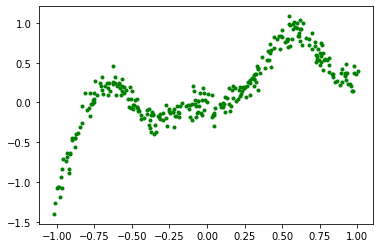

In [26]:
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [27]:
def convert_leaf_to_decision_node(node):
    parent = node.parent

    
    dn = DecisionNode(parent.input_dim, parent.output_dim, parent.optimizer, parent.leaf_optimizer)
    dn.node0 = LeafNode(dn, node.linear.weights, node.linear.bias)
    dn.node1 = LeafNode(dn, node.linear.weights, node.linear.bias)
    if parent.node0 is node:
        del parent.node0
        parent.node0 = dn
    elif parent.node1 is node:
        del parent.node1
        parent.node1 = dn
    else:
        print(parent.node0, parent.node1, node)
        print("Error occoured -- Problem in Algorithm")
    return

def add_node_to_tree(tree):
    try:
        node = tree.get_maximum_error_node()
        convert_leaf_to_decision_node(node)
    except:
        print("Error occoured while converting leaf node to decision Node")
    return

In [28]:
# optimizer=tnn.Adam()
# hdt = DecisionNode(1,1,optimizer)
# hdt0 = LeafNode(hdt)
# hdt1 = DecisionNode(1,1,optimizer)
# hdt10 = LeafNode(hdt1)
# hdt11 = LeafNode(hdt1)

# hdt.node0 = hdt0
# hdt1.node0 = hdt10
# hdt1.node1 = hdt11
# hdt.node1 = hdt1

In [41]:
optimizer = tnn.Adam(0.01)
leaf_optimizer = tnn.Adam(0.01)
hdt = DecisionNode(1, 1, optimizer, leaf_optimizer)
hdt.create_child(depth=2)

In [42]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(100000):
    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        ax.scatter(x, y, marker='.', color='g')
        ax.scatter(x, yout.reshape(-1), color='r', marker='.')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.21414540607952123


100 Error =  0.09008970268807426


200 Error =  0.08459385852032557


300 Error =  0.08172989036702714


400 Error =  0.07817779295197282


500 Error =  0.07499203417188788


600 Error =  0.05214061357352195


700 Error =  0.03912199009786937


800 Error =  0.03179454209492999


900 Error =  0.027479253480208823


1000 Error =  0.022202662022740512


1100 Error =  0.02153324608487096


1200 Error =  0.021106366551657704


1300 Error =  0.019900724895599492


1400 Error =  0.01948128425375222


1500 Error =  0.018817779839689658


1600 Error =  0.01892262684128283


1700 Error =  0.01867563445844098


1800 Error =  0.018358419243688542


1900 Error =  0.018310730456029798


2000 Error =  0.019188245836982306


2100 Error =  0.019058930956144606


2200 Error =  0.018952950515986076


2300 Error =  0.01886451597168913


2400 Error =  0.01882739435174119


2500 Error =  0.01923608407174326


2600 Error =  0.019071543721671993


2700 Error =  0.0194059392386

TclError: invalid command name "."

In [38]:
hdt.node0.node0.linear.weights.shape

(1, 1)

In [31]:
add_node_to_tree(hdt)

In [32]:
hdt.print_tree()

DN:(0)
|     DN:(1)
|     |     Leaf:(2)
|     |     DN:(2)
|     |     |     Leaf:(3)
|     |     |     Leaf:(3)
|     DN:(1)
|     |     Leaf:(2)
|     |     Leaf:(2)


## On 2D dataset

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
% matplotlib tk

In [12]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

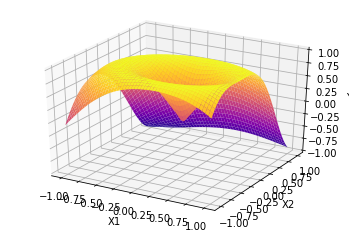

In [13]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [14]:
xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

## Building Decision Tree

In [16]:
optimizer = tnn.Adam(0.01)
leaf_optimizer = tnn.Adam(0.03)
hdt = DecisionNode(2, 1, optimizer, leaf_optimizer)
hdt.create_child(depth=3)

In [17]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.5639648664243325


100 Error =  0.047942801144608686


200 Error =  0.024396198254167382


300 Error =  0.025139032341274722


400 Error =  0.025157229553899638


500 Error =  0.026314162270183607


600 Error =  0.025716770267720478


700 Error =  0.023990504332082493


800 Error =  0.02292900272248967


900 Error =  0.021973283045746875


1000 Error =  0.02136297544234253


1100 Error =  0.02083266411846241


1200 Error =  0.020359284978195818


1300 Error =  0.02005099460263051


1400 Error =  0.020066945891894755


1500 Error =  0.020589344888136164


1600 Error =  0.019861248985203715


1700 Error =  0.020106525023539483


1800 Error =  0.020120299188871506


1900 Error =  0.020029898409886636


2000 Error =  0.019736799998517636


2100 Error =  0.01959254530401354


2200 Error =  0.01919345842957613


2300 Error =  0.019049805533502183


2400 Error =  0.019055921821678555


2500 Error =  0.018940165517845255


2600 Error =  0.01901729067122072


2700 Error =  0.018892

TclError: invalid command name "."

In [44]:
add_node_to_tree(hdt)

In [45]:
hdt.print_tree()

DN:(0)
|     DN:(1)
|     |     DN:(2)
|     |     |     Leaf:(3)
|     |     |     Leaf:(3)
|     |     Leaf:(2)
|     DN:(1)
|     |     Leaf:(2)
|     |     Leaf:(2)
